## Neuron example - 2+ delays

In this example the delay differential equation (DDE) system is used to model the interaction between two neurons, $x_1$ and $x_2$. The DDE system is given by:
```math
\begin{align}
  \dot{x}_1&= -\kappa x_1(t) + \beta \tanh(x_1(t-\tau_s)) + a_{12} \tanh(x_2(t-\tau_2))\\
  \dot{x}_2&=-\kappa x_2(t) + \beta \tanh(x_2(t-\tau_s)) + a_{21} \tanh(x_2(t-\tau_1))
\end{align}
```
where $\tau_1$ and $\tau_2$ are the delays between neurons 1 and 2 and where $\tau_s$ is the delay between each neuron getting a stimulus and reacting to that stimulus. This example is the a demo for showing how MATLAB's DDE-Biftool works (*DDE-BIFTOOL demo 1 - Neuron*, 2014).

The following packages and functions are needed for this demo:

In [24]:
using CairoMakie
using LinearAlgebra
include("../DDETools/DDETools.jl")
using .DDETools
include("neuronfunc.jl") #system of neuron example
include("neurontau.jl") #Delay forumla for neuron example

neurontau (generic function with 1 method)

In [25]:
#Values of parameters (same as those given in the Neuron demo for DDE-Biftool)
k=0.5
beta=-1
a12=1
a21=2.34 
tau1=0.2
tau2=0.2
taus=1.5

nd=3 #there are 3 delays
y01,feq=DDETools.create_ststfunc(neuronfunc,[0.0,0],[k,beta,a12,a21,tau1,tau2,taus], nd, par_indx=4)#varying paramter a21 so parameter index is 4
#The above outputs an initial equilibirium and a function to find the equilibria

([0.0, 0.0, 2.34], Main.DDETools.var"#f_equilibrium#24"{Int64, typeof(neuronfunc), Vector{Float64}, Int64, Int64}(4, Main.neuronfunc, [0.5, -1.0, 1.0, 2.34, 0.2, 0.2, 1.5], 3, 2))

In [26]:
#check equilibrium (f(x*,...,x*)=0)
xvec=[fill(0.0,2) for _ in 1:nd+1]
neuronfunc(xvec,[k,beta,a12,a21,tau1,tau2,taus])

2-element Vector{Float64}:
 0.0
 0.0

# Equilibria branch and stability

Finding the stability of equilibiria of DDEs is more complex than finding the stability of equilibria of ODEs due to the infinite dimensional past of DDEs. For this part of the example, the stability was found by using a large matrix that can be used to create a finite-dimensional system that can approximate the stability of the equilibria. The function ``` stab_func_matrix ``` utilises this method and has a first output of `1` if the equilibrium point is stable and has `0` if it is unstable. Below we find the stability of one equilibrium point (0,0) with $a_{21}$=2.34:

In [27]:
#Test stability of initial point (it should be unstable)
x0=y01[1:2]
p0=y01[3]
stabi,eigvalsi,eigvecs1=DDETools.stab_func_matrix(neuronfunc,neurontau,x0,[p0],[k,beta,a12,a21,tau1,tau2,taus],[4],nd,doprint=1)
unstabindx=findfirst(isequal(1),real(eigvalsi).>0)
unstabeigi=eigvalsi[unstabindx]

println("The stability is: $stabi (unstable)")
println("The eigenvalues are: $eigvalsi")
println("The unstable eigenvalue $unstabeigi") #this value matches that given in DDE-Biftool example so confirms stab_func_matrix is working correctly

The stability is: 0 (unstable)
The eigenvalues are: ComplexF64[-968.7660348033869 + 0.0im, -968.5375195436284 - 14.65339689928732im, -968.5375195436284 + 14.65339689928732im, -967.8521945592682 - 29.292579296848565im, -967.8521945592682 + 29.292579296848565im, -966.7107220202562 - 43.903346422560524im, -966.7107220202562 + 43.903346422560524im, -965.1142048297887 - 58.47152495663952im, -965.1142048297887 + 58.47152495663952im, -963.0641855544388 - 72.98298272084966im, -963.0641855544388 + 72.98298272084966im, -960.5626449277916 - 87.42364233092222im, -960.5626449277916 + 87.42364233092222im, -957.611999929625 - 101.77949479477972im, -957.611999929625 + 101.77949479477972im, -954.2151014409419 - 116.03661304494617im, -954.2151014409419 + 116.03661304494617im, -950.3752314791416 - 130.18116539139066im, -950.3752314791416 + 130.18116539139066im, -946.0961000139613 - 144.19942888144604im, -946.0961000139613 + 144.19942888144604im, -941.3818413687854 - 158.07780255472454im, -941.38184136878

We now find the equilibria branch whilst varying the parameter $a_{21}$ and then find stability of these equilibrium points again using ```stab_func_matrix```:

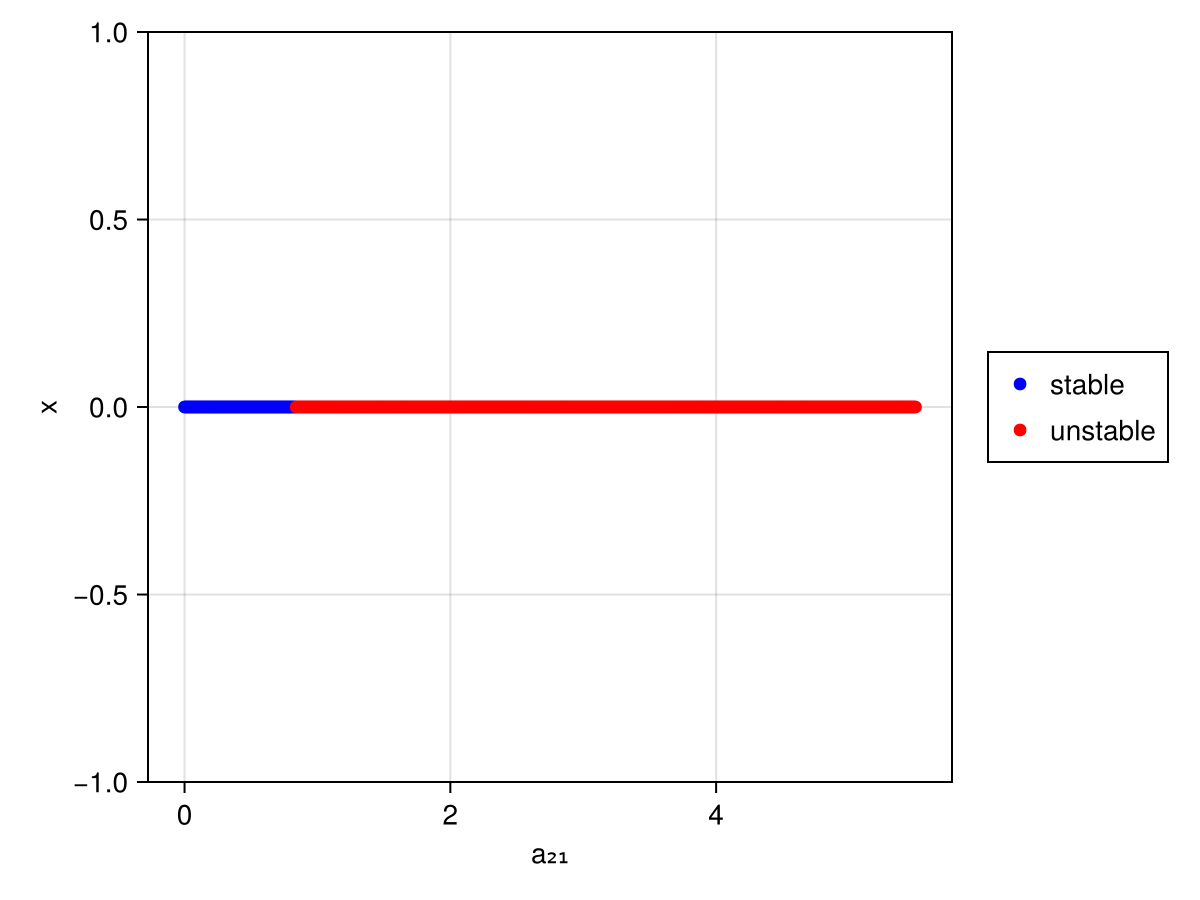

In [28]:
y02,feq2=DDETools.create_ststfunc(neuronfunc,[0.0,0],[k,beta,a12,0,tau1,tau2,taus], nd, par_indx=4) #we set a21 to 0 and find starting point for equilibria branching
alist1,ytan1=DDETools.track_curve(feq2,y02,[0.0,0,1],nmax=550) #tracks equilibria to give equilibria branch

xmat1=hcat([u[1] for u in alist1],[u[2] for u in alist1]) #finds the values of x1 and x2 for the equilibria
xlist1=[xmat1[i,:] for i in 1:size(xmat1,1)] #creates a vector of vectors of all the equilibria points

plist1=[u[3] for u in alist1] #A vector of the values of a21 for the equilibria points

m=100 #number of discretised steps
n=2 #number of states (x1,x2)
neq=length(plist1) #number of equilibrium points we're finding the stability of
stab=fill(NaN,neq)
eigvals1=[fill(0.0+0.0*im,n*(1+nd*m)) for _ in 1:neq] #blank array for all eigenvalues found for the equilibria points

for i in 1:neq
    stab[i],eigvals1[i],=DDETools.stab_func_matrix(neuronfunc,neurontau,xlist1[i],[plist1[i]],[k,beta,a12,a21,tau1,tau2,taus],[4],nd,doprint=1,m=m) #outputs the stability (1 for stable, 0 for unstable) and also gives the eigenvalues for each point
end

stable=(stab.==1.0) #highlights indices of stable points (indicated by a 1 in stable vector)
unstable=(stab.==0.0) #highlights indices of unstable points (indicated by a 1 in unstable vector)

#Below plots the equilibria and shows their stability
fig1=Figure()
ax1=Axis(fig1[1,1],xlabel="a₂₁",ylabel="x")
scatter!(ax1,plist1[stable],[u[1] for u in xlist1[stable]],label="stable",color="blue")
scatter!(ax1,plist1[unstable],[u[1] for u in xlist1[unstable]],label="unstable",color="red")
Legend(fig1[1,2], ax1, merge=true)
fig1

# Stability using Breda et al (2009) method

The function ```stab_func_DDE``` uses the method described in (Breda et al 2009) to find the stability and the eigenvalues (and if asked the eigenvectors) of an equilibrium point. For more information on this function, see the "Stability_finding_for_DDEs.ipynb" notebook located in the "DDE_stability_breda_et_al" folder. To use ```stab_func_DDE``` for this example, the partial derivative matrices $A_0, A_1,A_2, A_3$ need to be found for the equilibrium point(s). These matrcies can be found either manually or by using ```f_deriv```. In this example we'll use ```f_deriv``` so we can loop over all equilibrium points.

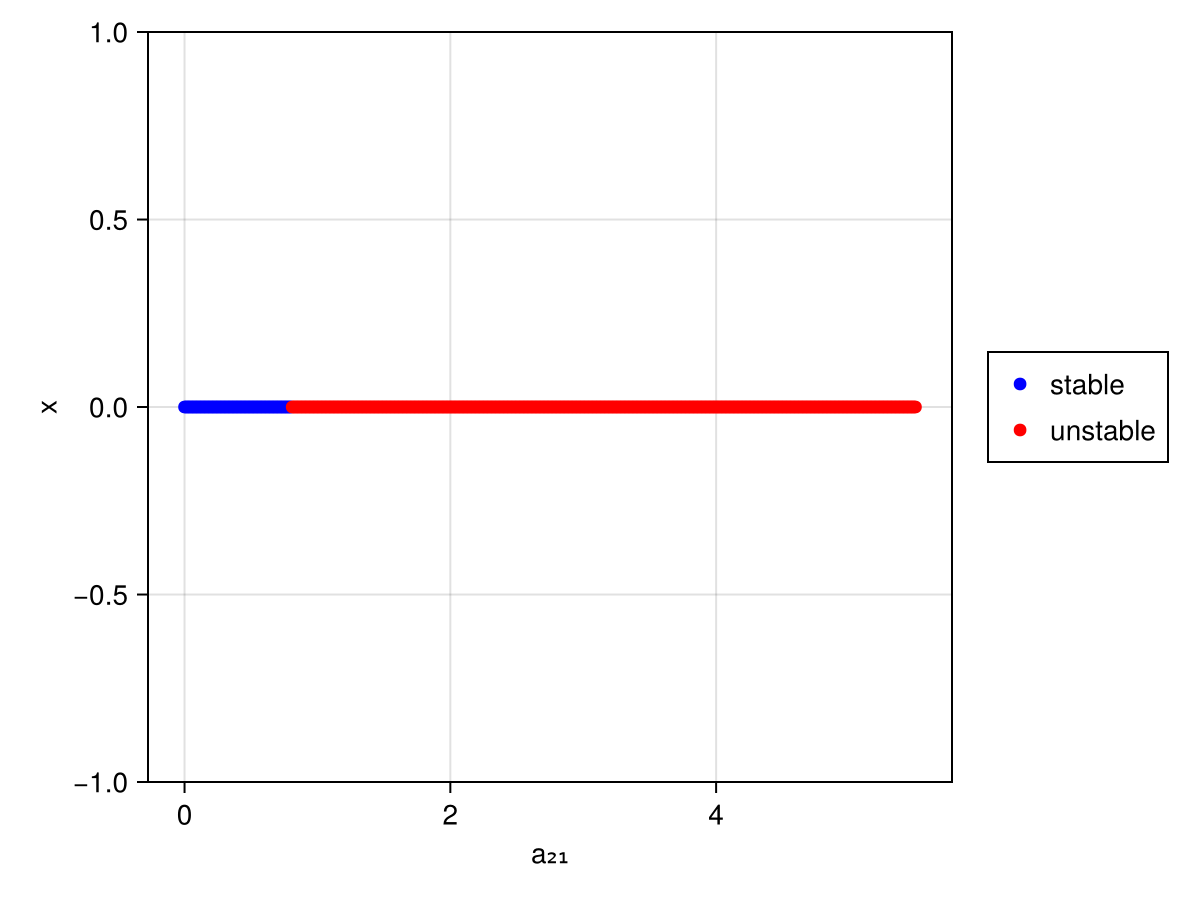

In [29]:
N=30 #so there are 31 interpolation points
neq=length(plist1) #number of equilibrium points we're finding the stability of
stab_DDE=fill(NaN,neq)

for i in 1:neq
    A0=DDETools.f_deriv(neuronfunc, xlist1[i], [k,beta,a12,plist1[i],tau1,tau2,taus],nd,nx=1) #finds partial derivative matrix with respect to x(t)
    A1=DDETools.f_deriv(neuronfunc, xlist1[i], [k,beta,a12,plist1[i],tau1,tau2,taus],nd,nx=2) #finds partial derivative matrix with respect to x(t-τ_1)
    A2=DDETools.f_deriv(neuronfunc, xlist1[i], [k,beta,a12,plist1[i],tau1,tau2,taus],nd,nx=3) #finds partial derivative matrix with respect to x(t-τ_2)
    A3=DDETools.f_deriv(neuronfunc, xlist1[i], [k,beta,a12,plist1[i],tau1,tau2,taus],nd,nx=4) #finds partial derivative matrix with respect to x(t-τ_s)
    stab_DDE[i],=DDETools.stab_func_DDE([A0,A1,A2,A3],[tau1,tau2,taus],N) #gives stability of each equilibrium point
end

stableDDE=(stab_DDE.==1.0) #highlights indices of stable points (indicated by a 1 in stable vector)
unstableDDE=(stab_DDE.==0.0)#highlights indices of unstable points (indicated by a 1 in unstable vector)

#Below plots the equilibria and shows their stability
fig2=Figure()
ax2=Axis(fig2[1,1],xlabel="a₂₁",ylabel="x")
scatter!(ax2,plist1[stableDDE],[u[1] for u in xlist1[stableDDE]],label="stable",color="blue")
scatter!(ax2,plist1[unstableDDE],[u[1] for u in xlist1[unstableDDE]],label="unstable",color="red")
Legend(fig2[1,2], ax2, merge=true)
fig2

Notice that the Breda et al method (used in ```stab_func_DDE```) is much quicker at finding stability, taking a few seconds, than approximating it using a large matrix (method used in ```stab_func_matrix```), which takes over a minute.

# Hopf bifurcation

The eigenvalues of the linearised system determine the equilibrium's stability. Below gives a plot of the real part of the rightmost eigenvalues for the equilibria.

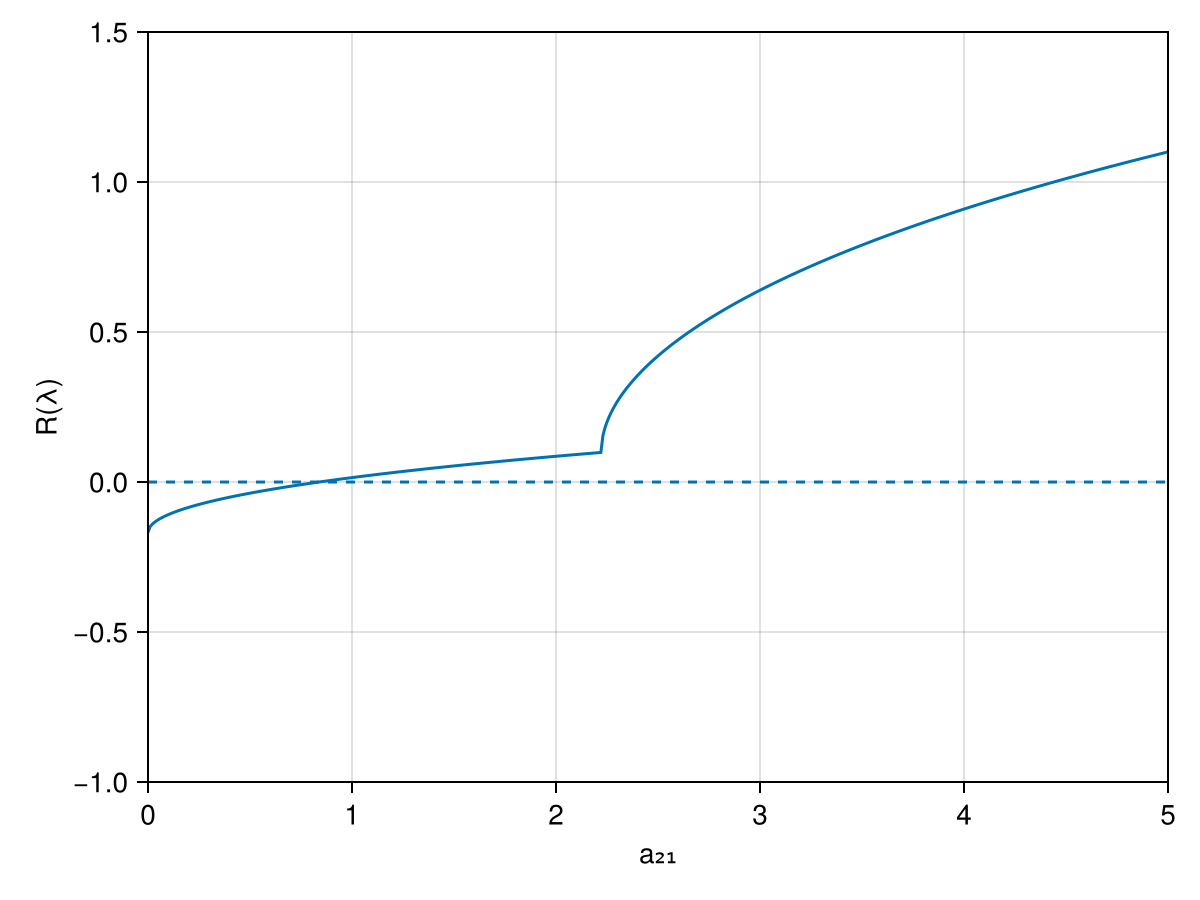

In [ ]:
avals=[u[3] for u in alist1] #list of a21  values
realeigs=real(eigvals1) #gets real parts of all eigenvalues for each tracked point
n_eq=length(avals) #number of equilibrium points

maxrealeigs=fill(NaN,n_eq) #blank array for largest real part of an eigenvalue for each equilibrium point

for i in 1:n_eq
    realindx=argmax(realeigs[i]) #finds index of largest real part of eigenvalues for a21 value
    maxrealeigs[i]=realeigs[i][realindx] #the largest real part of eigenvalues for the a21 value (needed as largest real part dictates if a point is stable (<0) or unstable (>0))
end

#Below plots the largest real eigenvalue part for varying parameter a21
fig3=Figure()
ax3=Axis(fig3[1,1],xlabel="a₂₁",ylabel="R(λ)")
lines!(ax3,avals,maxrealeigs)
xlims!(ax3,[0.0,5])
ylims!(ax3,[-1,1.5])
hlines!(ax3,0,linestyle=:dash) #horiztonal line at R(λ)=0 to indicate imagainary axis
fig3

A Hopf bifurcation occurs when the stability behaviour changes and a pair of complex conjugate eigenvalues of the linearised system crosses the imaginary axis and become purely imaginary, i.e. $\lambda=\pm \omega i$. We start to find the Hopf parameters by first finding the initial guess of the $a_{21}$ value for the Hopf bifurcation.

Note that while the initial guess of $a_{21}$ for a Hopf bifurcation can be found using both ```stab_func_matrix``` and ```stab_func_DDE```, the true Hopf bifurcation can only be found when using the stability function ```stab_func_matrix``` as ```create_hopffunc``` has been made to, currently, only work for ```stab_func_matrix```. The code for finding the initial guesses of $a_{21}$ for the two different stability methods is given below:

In [31]:
#We aim to find where the eigenvalues cross the imaginary axis (and become purely imaginary)
#Finds initial a21 value for Hopf bifurcation from stab_func_matrix results
unstab_indx=findfirst(isequal(0.0),stab) #find index of stability change
a21unstab=avals[unstab_indx] #initial guess of a21 value for Hopf bifurcation

0.8400000000000005

In [32]:
#Finds initial a21 value for Hopf bifurcation from stab_func_DDE results
unstab_DDEindx=findfirst(isequal(0.0),stab_DDE) #finds index of Hopf bifurcation (for stability vector given by stab_func_DDE)
a21unstabDDE=plist1[unstab_DDEindx] #finds initial guess for parameter a21 value for a Hopf bifurcation

0.8100000000000005

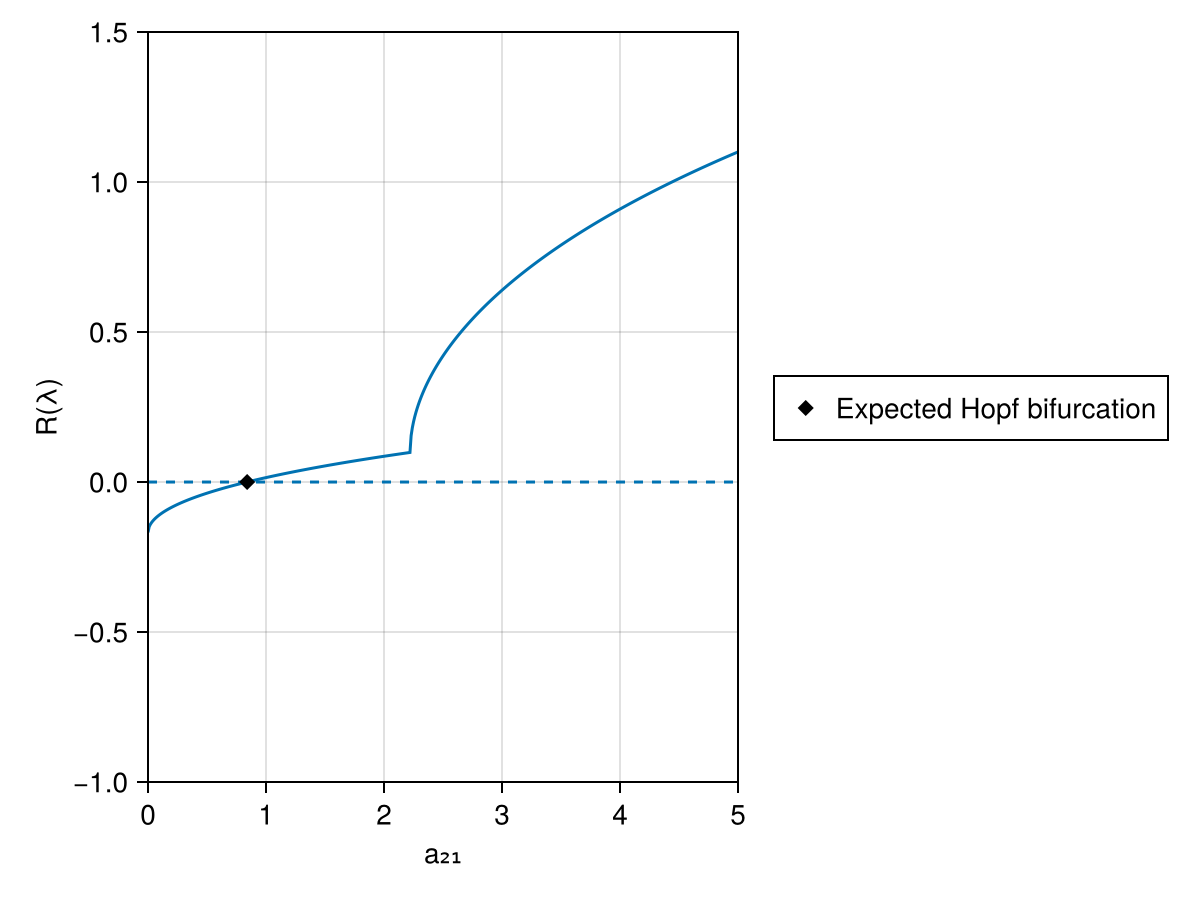

In [33]:
#Below plots Figure 3 but with the suspected Hopf bifurcation values plotted as well
fig4=Figure()
ax4=Axis(fig4[1,1],xlabel="a₂₁",ylabel="R(λ)")
lines!(ax4,avals,maxrealeigs)
xlims!(ax4,[0.0,5])
ylims!(ax4,[-1,1.5])
hlines!(ax4,0,linestyle=:dash) #horiztonal line at R(λ)=0 to indicate imagainary axis
scatter!(ax4,a21unstab,maxrealeigs[unstab_indx],color=:black,marker=:diamond, label="Expected Hopf bifurcation")
Legend(fig4[1,2], ax4, merge=true)
fig4

Now we have an initial guess (taking the one obtained from ```stab_func_matrix```) for the Hopf parameters, we find the true parameter values:

In [34]:
yh01,fhopf=DDETools.create_hopffunc(neuronfunc,neurontau,[k,beta,a12,0,tau1,tau2,taus],xlist1[unstab_indx],[a21unstab],[4],nd) #outputs initial guess of the Hopf bifurcation (including x, ω and a21 estimates) and a function that contains the method/formula to find the Hopf bifurcation
println("The initial guess for Hopf info: $yh01")
yh1,conv1,=DDETools.newton(fhopf,yh01) #putting initial guess and Hopf function into newton we get the true parameter values and information for the Hopf bifurcation
println("The true information for the Hopf bifurcation: $yh1")
println("converged?: $conv1")
a_hopf=yh1[end]
om_hopf=yh1[end-1]
x_hopf=yh1[1:2]
println("The ω value for Hopf bifurcation: $om_hopf")
println("The a21 value for Hopf bifurcation: $a_hopf")

The initial guess for Hopf info: [0.0, 0.0, -0.7372097807744701, -0.6756639246921932, 0.0, 3.526043721116034e-14, 0.7668092696644265, 0.8400000000000005]
The true information for the Hopf bifurcation: [0.0, 0.0, -0.7438855391134424, -0.6683070437290806, 1.7528156689931815e-14, 1.5751721548947158e-14, 0.7819651620459527, 0.8071232251830753]
converged?: true
The ω value for Hopf bifurcation: 0.7819651620459527
The a21 value for Hopf bifurcation: 0.8071232251830753


In [35]:
println("The estimated a21 value for Hopf bifurcation using large matrix stability (stab_func_matrix) is: $a21unstab")
println("The estimated a21 value for Hopf bifurcation using stab_func_DDE is: $a21unstabDDE")
println("True a21 value for Hopf bifurcation given by stab_func_matrix: $a_hopf")

The estimated a21 value for Hopf bifurcation using large matrix stability (stab_func_matrix) is: 0.8400000000000005
The estimated a21 value for Hopf bifurcation using stab_func_DDE is: 0.8100000000000005
True a21 value for Hopf bifurcation given by stab_func_matrix: 0.8071232251830753


We see that ```stab_func_DDE``` is more accurate than ```stab_func_matrix``` as the initial guess of the Hopf $a_{21}$ value obtained from ```stab_func_DDE``` ($\approx 0.81$) is closer to the true $a_{21}$ Hopf value ($\approx 0.807$) than the initial guess of $a_{21}$ when using ```stab_func_matrix``` ($\approx 0.84$).

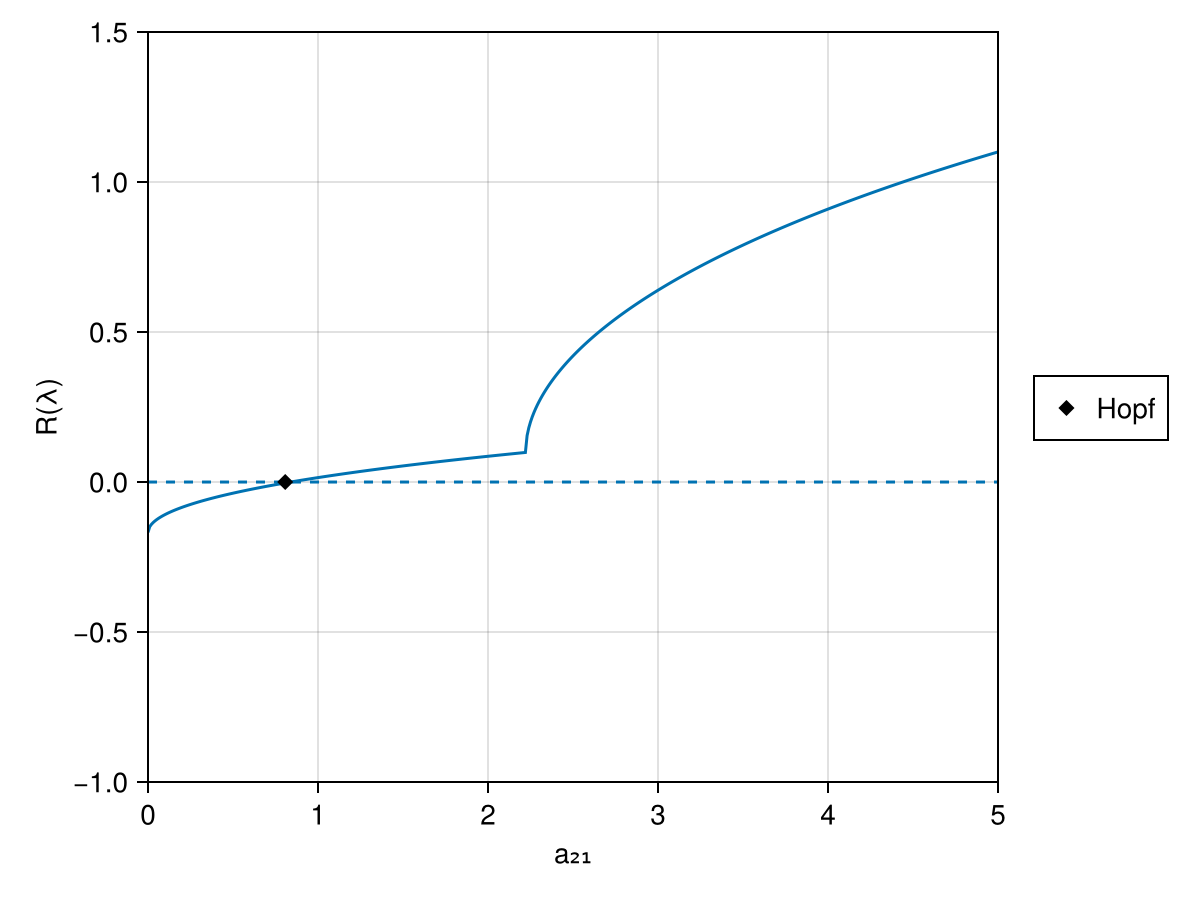

In [36]:
#Below plots Figure 3 but with the true Hopf bifurcation values plotted as well
fig5=Figure()
ax5=Axis(fig5[1,1],xlabel="a₂₁",ylabel="R(λ)")
lines!(ax5,avals,maxrealeigs)
xlims!(ax5,[0.0,5])
ylims!(ax5,[-1,1.5])
hlines!(ax5,0,linestyle=:dash) #horiztonal line at R(λ)=0 to indicate imagainary axis
scatter!(ax5,a_hopf,0,color=:black,marker=:diamond, label="Hopf") #true value of Hopf plotted at a=a_hopf and R(λ)=0
Legend(fig5[1,2], ax5, merge=true)
fig5

We can test the above Hopf values by checking the following hold (which have been obtained by manipulating from the characteristic equation with $\lambda=+ \omega i$):
```math 
\begin{align*}
- \omega^2 -2\omega \beta \sin(\omega \tau_s) - 2 \kappa \beta \cos(\omega \tau_s) + \kappa^2 + \beta^2 \cos(2 \omega \tau_s) - a_{21}a_{12} \cos(\omega(\tau_1 +\tau_2))=0 \tag{3}\\
2\omega \kappa - 2\omega \beta \cos(\omega \tau_s)+ 2\kappa \beta \sin(\omega \tau_s)-\beta^2 \sin(2 \omega \tau_s) + a_{21}a_{12} \sin(\omega (\tau_1 +\tau_2))=0 \tag{4}
\end{align*}
```

In [40]:
eq3ans=-(om_hopf)^2 -2*om_hopf*beta*sin(om_hopf*taus) - 2*k*beta*cos(om_hopf*taus)+k^2+(beta^2)*cos(2*om_hopf*taus) -a_hopf*a12*cos(om_hopf*(tau1+tau2))
println("Using the found Hopf bifurcation values above, the answer to Equation (3) is $eq3ans, which is close to 0 so the found Hopf values are correct with a reasonable accuracy")

Using the found Hopf bifurcation values above, the answer to Equation (3) is -3.687616878522704e-11, which is close to 0 so the found Hopf values are correct with a reasonable accuracy


In [41]:
eq4ans=2*om_hopf*k - 2*om_hopf*beta*cos(om_hopf*taus)+2*k*beta*sin(om_hopf*taus)-(beta^2)*sin(2*om_hopf*taus)+a_hopf*a12*sin(om_hopf*(tau1+tau2))
println("Using the found Hopf bifurcation values above, the answer to Equation (4) is $eq4ans, which is close to 0 so found Hopf values are correct with a reasonable accuracy" )

Using the found Hopf bifurcation values above, the answer to Equation (4) is -4.159839139816768e-11, which is close to 0 so found Hopf values are correct with a reasonable accuracy


Hence, the functions `create_hopffunc` and `newton` are working well to find the true Hopf bifurcation values.

# Continuation in ($a_{21}, \tau_s$)-plane

Finally, we continue the Hopf points in the $a_{21}$ and $\tau_s$ parameter plane:

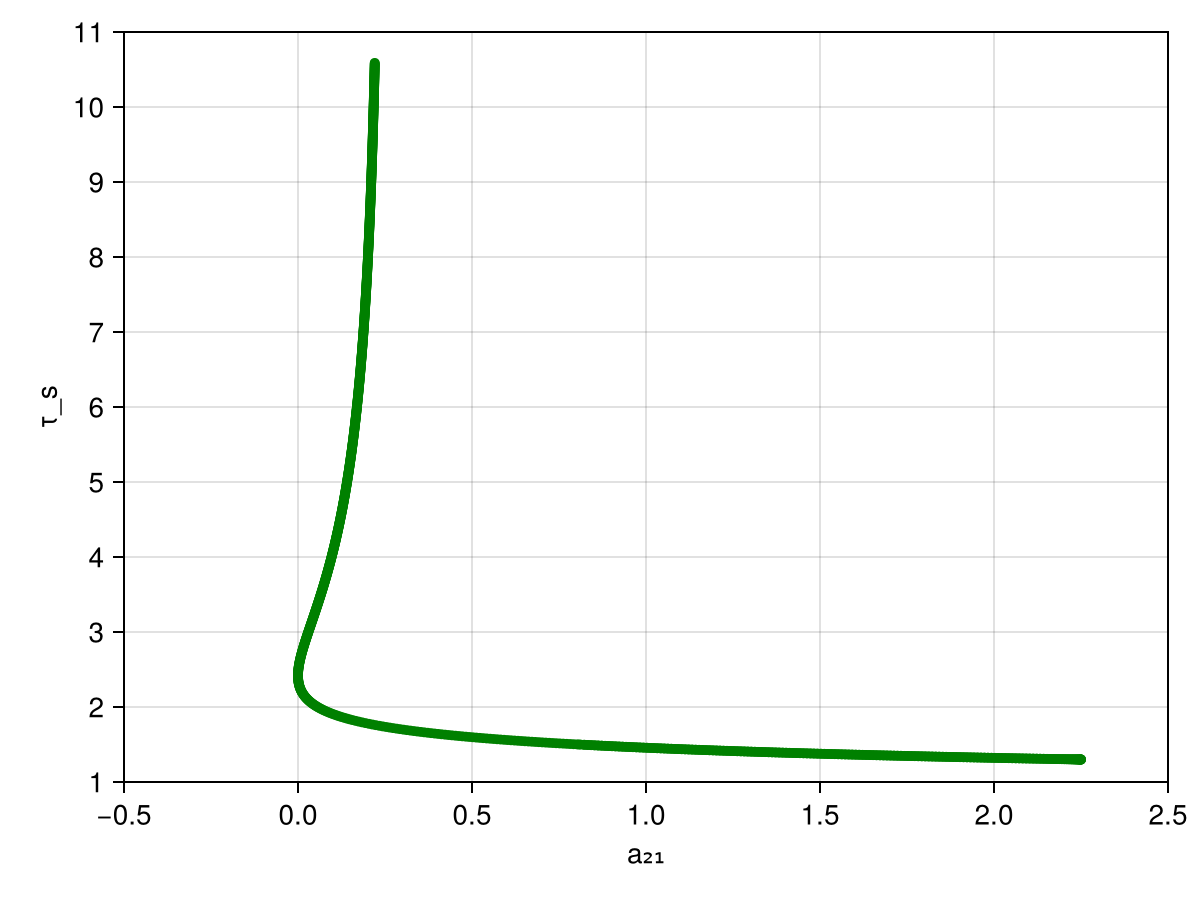

In [ ]:
yheq01,fhopfeq1=DDETools.create_hopffunc(neuronfunc,neurontau,[k,beta,a12,a_hopf,tau1,tau2,taus],x_hopf,[a_hopf,taus],[4,7],nd) #initialises Hopf function and initial guess for hopf information with a21≈0.81 and tau_s=1.5
yheqlist1,heqtan1=DDETools.track_curve(fhopfeq1,yheq01,[0.0,0,0,0,0,0,0,1,-1],nmax=1250) #tracks a21 and τ_s over (a21, τ_s) plane

#Plot of continuation/tracking in (a21,τ_s) plane
fig6=Figure()
ax6=Axis(fig6[1,1],xlabel="a₂₁",ylabel="τ_s")
scatter!(ax6,[u[end-1] for u in yheqlist1],[u[end] for u in yheqlist1],color="green",markersize=:7)
ylims!(ax6,[1,11])
xlims!(ax6,[-0.5,2.5])
ax6.xticks=-0.5:0.5:2.5 #creates x-axis increments that match those given in DDE-Biftool (makes comparsion between the two easier)
ax6.yticks=1:1:11 #creates y-axis increments that match those given in DDE-Biftool
fig6

# References

1. *DDE-BIFTOOL demo 1 - Neuron* (12/2014). Available at https://ddebiftool.sourceforge.net/demos/neuron/html/demo1.html (Accessed: 29 August 2025)
2. Breda D., Maset S., Vermiglio R. (2009). 'TRACE-DDE: a Tool for Robust Analysis and Characteristic Equations for Delay Differential Equations', *Lecture Notes in Control And Information Sciences*, volume 388, pp 145-155. Available at: http://dx.doi.org/10.1007/978-3-642-02897-7_13